In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from keras.models import load_model

import sys
sys.path.append('../sa4snli/')

from SNLI import SNLI
from layers import MHSA, PFNN


/home/hirotoshi/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
snli = SNLI()

# load data
snli = snli.load_data('../data/pickle/snli_pad_concat_glove6B.300d.pickle')
model = load_model('../model/mhsa_model_02.h5', custom_objects={'MHSA': MHSA, 'PFNN': PFNN})

index_to_word = {i: w for w, i in snli.tokenizer.word_index.items()}
index_to_word[0] = ''
i2w = lambda i: index_to_word[i]

In [3]:
embed_layer = model.layers[1]
mhsa_layer  = model.layers[2]
embed_weight = embed_layer.get_weights()[0]

# extract query and key weights
# 
mhsa_weights = mhsa_layer.get_weights()
wo_weight  = mhsa_weights.pop()
wq_weights = []
wk_weights = []
wv_weights = []
for i, weight in enumerate(mhsa_weights):
    if i % 3 == 0:
        wq_weights.append(weight)
    elif i % 3 == 1:
        wk_weights.append(weight)
    else:
        wv_weights.append(weight)

In [42]:
def create_attention_dataframes(number, heads=2, use_softmax=True):
    def softmax(x):
        exp_x = np.exp(x)
        y = exp_x / np.sum(np.exp(x), axis=1, keepdims=True)
        return y

    sentence = snli.x_test[number]
    df_list = []
    
    for i in range(heads):
    
        # calculate attention_weight
        word_indices = np.where(sentence != 0)[0]
        sl = np.vectorize(i2w)(sentence)
        sl = sl[~(sl == '')]

        wq_weight = wq_weights[i]
        wk_weight = wk_weights[i]

        encoded_sentence = np.zeros((sentence.shape[0], embed_weight.shape[1]))
        for i, index in enumerate(sentence):
            encoded_sentence[i, :] = embed_weight[index, :]

        qw = np.dot(encoded_sentence, wq_weight)
        kw = np.dot(encoded_sentence, wk_weight)

        # attention_weight
        aw = np.dot(qw, kw.T)/np.sqrt(300/heads)
        # softmax
        if use_softmax:
            aw = softmax(aw)

        df = pd.DataFrame(aw)
        # extract empty index

        f = df[word_indices].loc[word_indices]
        f.index = sl
        f.columns = sl

        df_list.append(f)

    return df_list

[                     a      land     rover            is         being  \
 a         2.332876e-10  0.000971  0.002542  1.375715e-05  8.410906e-04   
 land      4.050172e-13  0.160058  0.010522  7.317904e-07  5.322239e-05   
 rover     1.244920e-07  0.009631  0.103572  9.280950e-06  1.381267e-04   
 is        9.690212e-09  0.007696  0.002760  7.459204e-05  3.276328e-03   
 being     1.329386e-03  0.027397  0.004585  2.671759e-01  8.161103e-02   
 driven    1.001851e-11  0.009602  0.024969  3.132329e-07  1.344341e-04   
 across    2.980310e-16  0.002931  0.000069  2.479802e-08  2.356950e-07   
 a         2.332876e-10  0.000971  0.002542  1.375715e-05  8.410906e-04   
 river     1.174199e-30  0.002464  0.001108  1.969606e-18  2.776185e-11   
 |         2.226634e-25  0.001417  0.021677  1.959732e-16  3.724579e-11   
 a         2.332876e-10  0.000971  0.002542  1.375715e-05  8.410906e-04   
 vehicle   9.435516e-02  0.000655  0.000174  2.760603e-01  3.611127e-04   
 is        9.690212e-09  

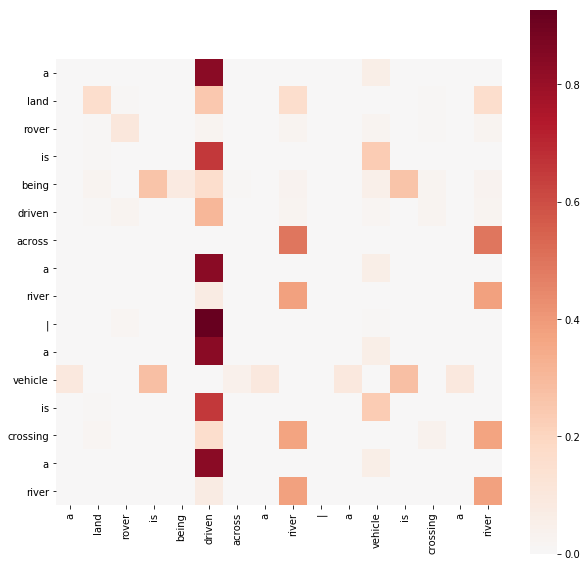

In [47]:
df_list_13 = create_attention_dataframes(13, 2, True)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_list_13[0], square=True, center=0, cmap='RdBu_r')
plt.savefig('../data/figs/num13_head01.png')

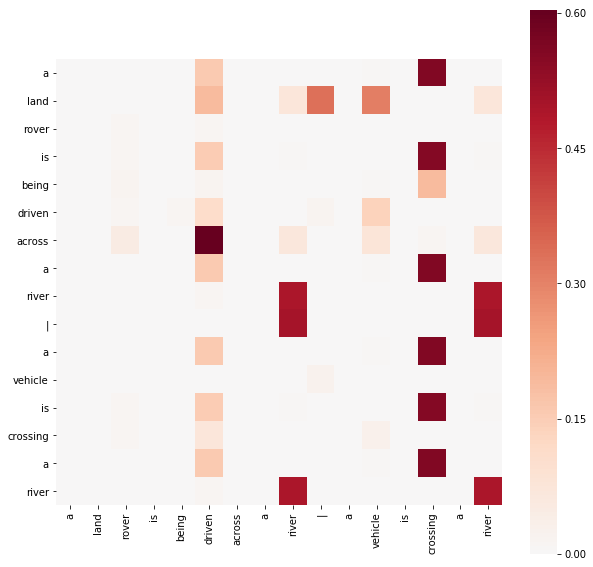

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_list_13[1], square=True, center=0, cmap='RdBu_r')
plt.savefig('../data/figs/num13_head02.png')

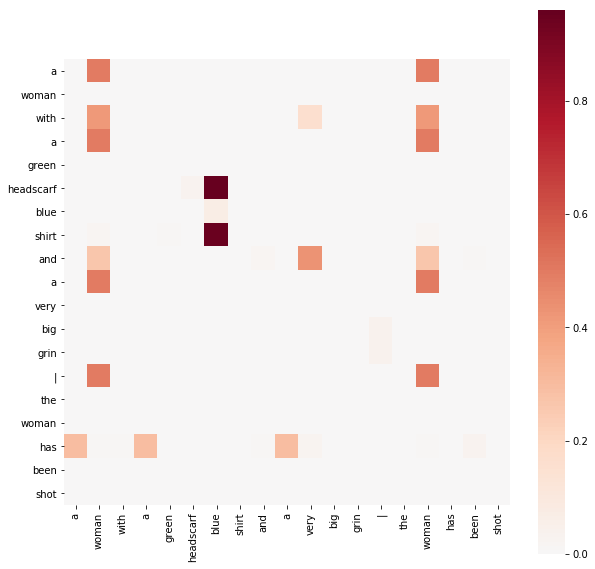

In [52]:
df_list_5 = create_attention_dataframes(5, 2, True)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_list_5[0], square=True, center=0, cmap='RdBu_r')
plt.savefig('../data/figs/num5_head01.png')

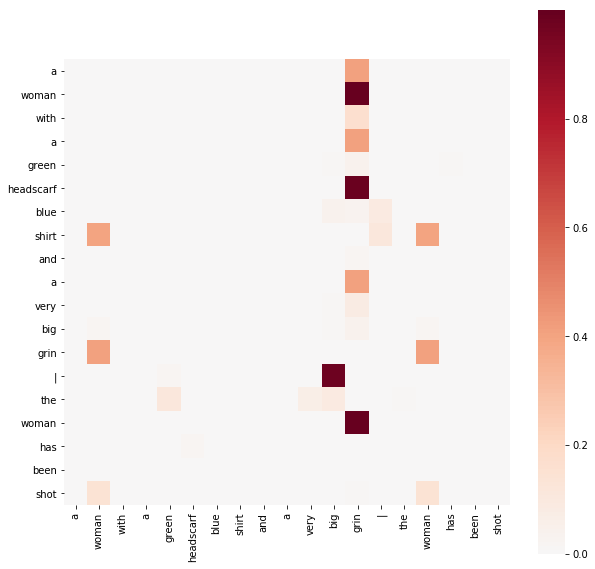

In [53]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_list_5[1], square=True, center=0, cmap='RdBu_r')
plt.savefig('../data/figs/num5_head02.png')